In [1]:
!date

Fri Feb 28 15:18:39 PST 2020


# Validate 10x and SS at with 3' amount

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [12]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [13]:
t2g["transcript_id"] = t2g["transcript_id"].str.slice(0,18)
t2g["gene_id"] = t2g["gene_id"].str.slice(0,18)

In [14]:
def swap_start(start, stop, strand):
    new_start = start
    new_stop = stop
    if strand=="-":
        new_start = stop
        new_stop = start
    return new_start, new_stop

In [15]:
tmp = t2g.apply(lambda x: swap_start(x["start"], x["stop"], x["strand"]), axis=1).tolist()
t2g[["new_start", "new_stop"]] = pd.DataFrame(tmp, columns=["new_start", "new_stop"])

In [16]:
t2g.index = t2g.transcript_id.values

# Group isoforms by (1) Gene and then (2) Transcripton start sites

In [17]:
gb = t2g.groupby(["chromosome", "gene_id", "new_start"])["transcript_id"].apply(list)
gb = gb.reset_index()
gb = gb.rename(columns={"transcript_id":"tss_same"})
gb["tss_len"] = gb["tss_same"].apply(lambda x: len(x))

In [18]:
gb["n_tss_same"]    = gb["tss_same"].apply(lambda x: len(x))

num_iso_per_gene   = t2g.groupby("gene_id")["transcript_id"].count()
max_tss_set_size    = gb.groupby("gene_id")["tss_len"].apply(max)
num_tss_with_1_iso  = gb.groupby("gene_id")["tss_len"].apply(lambda x: (np.array(x)==1).sum())

gb["n_iso"]         = gb["gene_id"].map(num_iso_per_gene)
gb["max_tss_size"]  = gb["gene_id"].map(max_tss_set_size)
gb["num_tss_1_iso"] = gb["gene_id"].map(num_tss_with_1_iso)

txn_list = gb["tss_same"].explode().values

#gb["tss_same"] = gb.tss_same.astype(str)
gb["tss_class"] = np.arange(gb.shape[0])

In [20]:
t2g = gb.sort_values("gene_id")

In [21]:
t2g

,chromosome,gene_id,new_start,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class
54497,3,ENSMUSG00000000001,108146146,[ENSMUST00000000001],1,1,1,1,1,54497
98714,X,ENSMUSG00000000003,77853530,[ENSMUST00000114041],1,1,2,1,2,98714
98715,X,ENSMUSG00000000003,77853623,[ENSMUST00000000003],1,1,2,1,2,98715
34398,16,ENSMUSG00000000028,18811591,[ENSMUST00000231819],1,1,4,1,4,34398
34399,16,ENSMUSG00000000028,18811626,[ENSMUST00000096990],1,1,4,1,4,34399
...,...,...,...,...,...,...,...,...,...,...
37760,16,ENSMUSG00000116987,91464803,[ENSMUST00000232135],1,1,1,1,1,37760
41805,17,ENSMUSG00000116988,8147788,[ENSMUST00000232307],1,1,1,1,1,41805
37761,16,ENSMUSG00000116989,90349417,[ENSMUST00000231361],1,1,1,1,1,37761
37762,16,ENSMUSG00000116993,86806364,[ENSMUST00000232333],1,1,2,1,2,37762


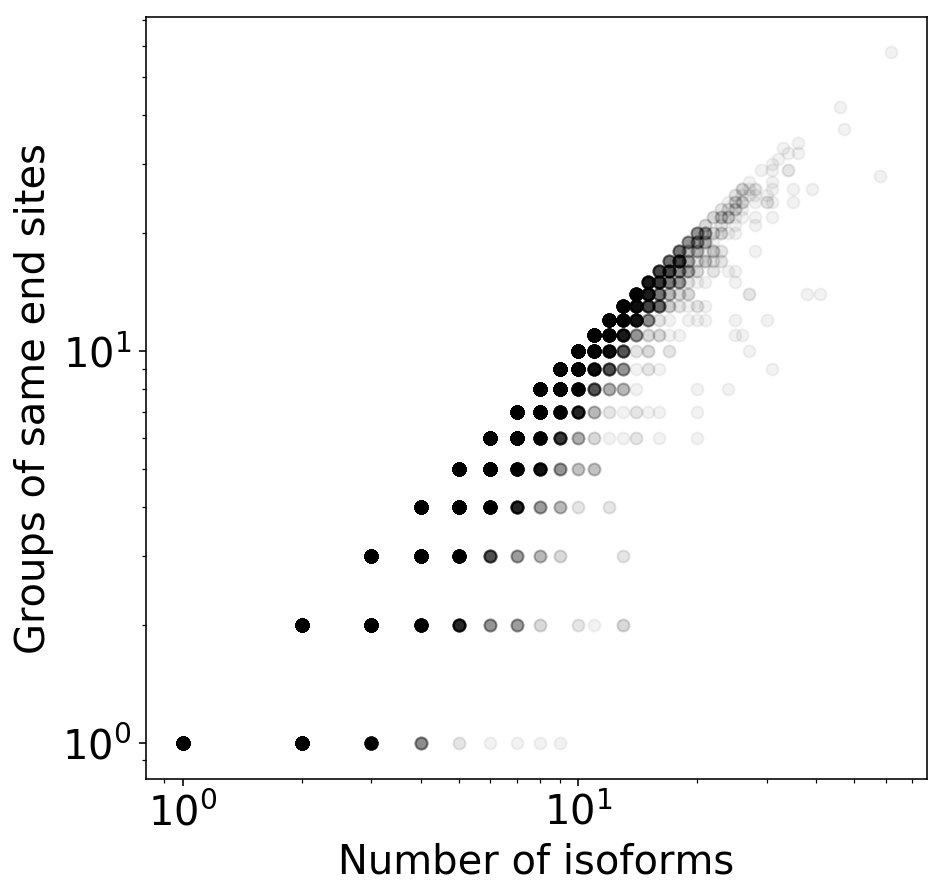

In [24]:
fig, ax = plt.subplots(figsize=(7,7))

x = t2g[~t2g["gene_id"].duplicated()]["n_iso"]
y = t2g.groupby("gene_id")["n_iso"].count()
alpha=0.05

ax.scatter(x,y, alpha=alpha, color="k")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Number of isoforms")
ax.set_ylabel("Groups of same end sites")

plt.savefig("./figures/end_sites.png", bbox_inches='tight', dpi=300)


plt.show()

In [25]:
t2g.to_csv("tables/t2g.csv")